In [21]:
%matplotlib inline
import os
import pickle
import numpy as np
import random as python_random
import sklearn
from sklearn.model_selection import RandomizedSearchCV, RepeatedKFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from scipy.stats import uniform, loguniform, randint
import pandas as pd
import xgboost
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns

In [22]:
# if os.getcwd().split("/")[-1] != 'intern-take-home-assessment':
#     os.chdir("./code/3m-internship/intern-take-home-assessment")

## Load Inference Data

In [23]:
infer_data = pd.read_csv('./preppared-data/infer-data.csv')

In [24]:
infer_data.head()

,location_id,date,temperature,pressure,humidity,cloudy,precipitation,season,is_weekend,population,...,month_03,month_04,month_05,month_06,month_07,month_08,month_09,month_10,month_11,month_12
0,13,2022-06-27,77.54,987.112676,0.97,0,0,summer,0,68818,...,0,0,0,1,0,0,0,0,0,0
1,12,2022-04-29,47.12,979.084507,0.99,0,0,summer,0,196528,...,0,1,0,0,0,0,0,0,0,0
2,11,2022-09-08,65.84,991.126761,0.80,1,0,winter,0,121465,...,0,0,0,0,0,0,1,0,0,0
3,13,2022-09-12,56.48,1008.967136,0.57,0,0,winter,0,68818,...,0,0,0,0,0,0,1,0,0,0
4,12,2022-04-18,50.00,1040.856808,0.88,0,0,summer,0,196528,...,0,1,0,0,0,0,0,0,0,0


We make the data ready for inference by removing extra columns and converting it to a numpy array.

In [25]:
X_infer = infer_data.drop(columns=['location_id', 'date', 'season']).to_numpy()
print(f'X_infer.shape: {X_infer.shape}')

X_infer.shape: (855, 20)


## Make Inference

In [26]:
model = pickle.load(open('./stored-models/xgb_reg.sav', 'rb'))
infer_data['predicted_profit'] = model.predict(X_infer)

## Results

Since we do not have weather data of all locations for each data in the dataset, instead of comparing the sum of the profit of each location from from January 1st through October 30th of 2022, we compare the average daily profit, by summing up the profits of each locations and dividing them by the number of days that we have data for each locations.

In [27]:
infer_data.groupby(['location_id'])[['predicted_profit']].agg(['mean'])

,predicted_profit
,mean
location_id,
11,26.127272
12,26.169758
13,26.103027


Although avaergae daily profit is higher for location Id 11, the following t-test shows that the difference between the means of profit is not statistically significant for confidence level of 95%.

In [28]:
l_11_profit = infer_data[infer_data.location_id == 11].predicted_profit.values 
l_12_profit = infer_data[infer_data.location_id == 12].predicted_profit.values
l_13_profit = infer_data[infer_data.location_id == 13].predicted_profit.values
print(f"T-test for mean profit difference of location Ids 11 and 12: {stats.ttest_ind(l_12_profit, l_11_profit)}")
print(f"T-test for mean profit difference of location Ids 11 and 13: {stats.ttest_ind(l_11_profit, l_13_profit)}")
print(f"T-test for mean profit difference of location Ids 12 and 13: {stats.ttest_ind(l_12_profit, l_13_profit)}")

T-test for mean profit difference of location Ids 11 and 12: Ttest_indResult(statistic=0.603094002164363, pvalue=0.546686886362121)
T-test for mean profit difference of location Ids 11 and 13: Ttest_indResult(statistic=0.3414041133623428, pvalue=0.7329263093106274)
T-test for mean profit difference of location Ids 12 and 13: Ttest_indResult(statistic=0.9581578575814464, pvalue=0.3383886767962647)


Next we look at the average daily profit, based on season.

In [29]:
infer_data.groupby(['location_id', 'season'])[['predicted_profit']].agg(['mean'])

predicted_profit
                               mean
location_id season                 
11          summer        26.043058
            winter        26.212688
12          summer        25.986698
            winter        26.347799
13          summer        26.079105
            winter        26.129236

The following t-test shows that at the level of 95% confidence, the average daily profit is not statistically different between three locations in summer, but location 12 has a higher statistically significant average daily profit compared to location 13 and a marginally significatn differnce compare to location 11.

In [30]:
# winter predictions for each location
l_11_winter = infer_data[(infer_data.location_id == 11) & (infer_data.season == 'winter')].predicted_profit.values
l_12_winter = infer_data[(infer_data.location_id == 12) & (infer_data.season == 'winter')].predicted_profit.values
l_13_winter = infer_data[(infer_data.location_id == 13) & (infer_data.season == 'winter')].predicted_profit.values
# winter predictions for each location
l_11_summer = infer_data[(infer_data.location_id == 11) & (infer_data.season == 'summer')].predicted_profit.values
l_12_summer = infer_data[(infer_data.location_id == 12) & (infer_data.season == 'summer')].predicted_profit.values
l_13_summer = infer_data[(infer_data.location_id == 13) & (infer_data.season == 'summer')].predicted_profit.values

print(f"T-test for summer mean profit difference of location Ids 11 and 12: {stats.ttest_ind(l_12_summer, l_11_summer)}")
print(f"T-test for summer mean profit difference of location Ids 11 and 13: {stats.ttest_ind(l_11_summer, l_13_summer)}")
print(f"T-test for summer mean profit difference of location Ids 12 and 13: {stats.ttest_ind(l_12_summer, l_13_summer)}")
print()
print(f"T-test for winter mean profit difference of location Ids 11 and 12: {stats.ttest_ind(l_12_winter, l_11_winter)} *")
print(f"T-test for winter mean profit difference of location Ids 11 and 13: {stats.ttest_ind(l_11_winter, l_13_winter)}")
print(f"T-test for winter mean profit difference of location Ids 12 and 13: {stats.ttest_ind(l_12_winter, l_13_winter)} **")

T-test for summer mean profit difference of location Ids 11 and 12: Ttest_indResult(statistic=-0.48052815323212295, pvalue=0.6312244520520456)
T-test for summer mean profit difference of location Ids 11 and 13: Ttest_indResult(statistic=-0.3378233981007842, pvalue=0.7357415311241191)
T-test for summer mean profit difference of location Ids 12 and 13: Ttest_indResult(statistic=-0.8222309076720712, pvalue=0.41162334713375137)

T-test for winter mean profit difference of location Ids 11 and 12: Ttest_indResult(statistic=1.7967163676631317, pvalue=0.07344316651109663) *
T-test for winter mean profit difference of location Ids 11 and 13: Ttest_indResult(statistic=0.9002182826675491, pvalue=0.3687946103510177)
T-test for winter mean profit difference of location Ids 12 and 13: Ttest_indResult(statistic=2.7811596858708763, pvalue=0.005784113515818976) **


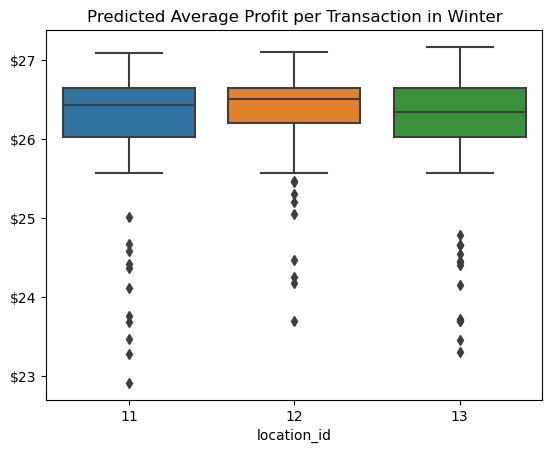

In [36]:
infer_winter = infer_data[infer_data.season == 'winter']
fig, ax = plt.subplots()
sns.boxplot(infer_winter, x='location_id', y='predicted_profit').set(ylabel=None, title='Predicted Average Profit per Transaction in Winter')

ax.yaxis.set_major_formatter('${x:1.0f}')

plt.savefig('./assets/inference.png', bbox_inches='tight')